## **Install Mask RCNN library**

In [0]:
!pip install git+https://github.com/matterport/Mask_RCNN.git

  Cloning https://github.com/matterport/Mask_RCNN.git to /tmp/pip-req-build-6kvdjnqx
  Running command git clone -q https://github.com/matterport/Mask_RCNN.git /tmp/pip-req-build-6kvdjnqx
  Created wheel for mask-rcnn: filename=mask_rcnn-2.1-cp36-none-any.whl size=56923 sha256=a88bb2927759a6d1b81d0cfefea562b565860211fd5df87b89aad80262b27beb
  Stored in directory: /tmp/pip-ephem-wheel-cache-gi6h3d9l/wheels/c2/db/78/1af79db27d80d68b0eb94d95fda90b8b2c2f6e8862b13d5d01
Successfully built mask-rcnn


## **Load libraries**

In [0]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros, asarray, expand_dims, mean
import urllib
import skimage.io
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes, compute_ap
from mrcnn.config import Config
from mrcnn.model import MaskRCNN, load_image_gt, mold_image
from mrcnn.utils import Dataset, compute_ap
from mrcnn.model import load_image_gt, mold_image
from mrcnn.visualize import display_instances

## **Download kangaroo image dataset**

In [0]:
!git clone https://github.com/experiencor/kangaroo.git

Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 53.19 MiB/s, done.
Resolving deltas: 100% (158/158), done.


## **Create class that defines and loads the kangaroo dataset**

In [0]:
# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):

  # load the dataset definitions
  def load_dataset(self, dataset_dir, is_train = True):
    # define one class
    self.add_class("dataset", 1, "kangaroo")
    # define data locations
    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annots/'
    # find all images
    for filename in listdir(images_dir):
      # extract image id
      image_id = filename[:-4]
      # skip bad images
      if image_id in ['00090']:
        continue
      # skip all images after 150 if we are building the train set
      if is_train and int(image_id) >= 150:
        continue
      # skip all images before 150 if we are building the test/val set
      if not is_train and int(image_id) < 150:
        continue
      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.xml'
      # add to dataset
      self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path)

    # function to extract bounding boxes from an annotation file
  def extract_boxes(self, filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract the bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
      xmin = int(box.find('xmin').text)
      ymin = int(box.find('ymin').text)
      xmax = int(box.find('xmax').text)
      ymax = int(box.find('ymax').text)
      coors = [xmin, ymin, xmax, ymax]
      boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

  # load the masks for an image
  def load_mask(self, image_id):
    # get details of the image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load XML
    boxes, w, h = self.extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype = 'uint8')
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('kangaroo'))
    return masks, asarray(class_ids, dtype = 'int32')

  # load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

## **Create training and test sets**

In [0]:
# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 131
Test: 32


## **Plot an image and bounding box**

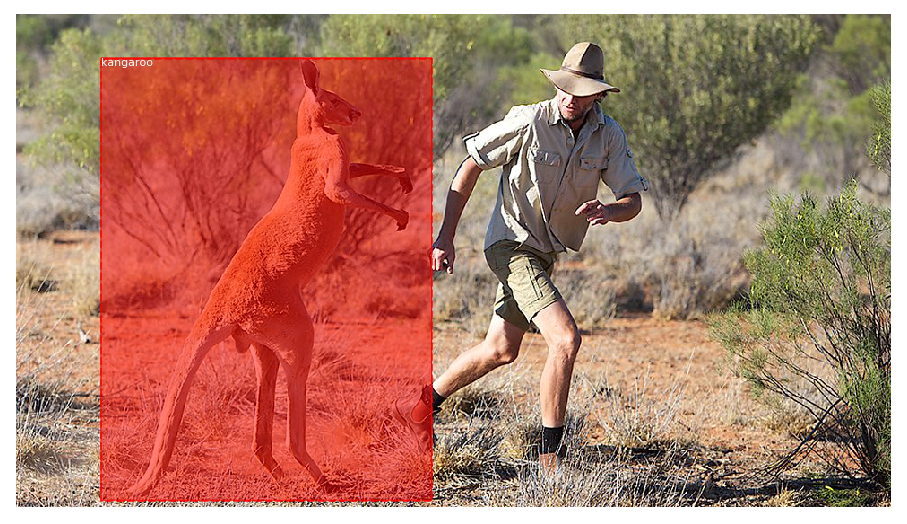

In [0]:


# define image id
image_id = 100

# load the image
image = train_set.load_image(image_id)

# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)

# extract the bounding boxes from the masks
bbox = extract_bboxes(mask)

# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

## **Set up model configuration**

In [0]:


# define a configuration for the model
class KangarooConfig(Config):
  # give the configuration a recognizable name
  NAME = 'kangaroo_cfg'
  # number of classes
  NUM_CLASSES = 1 + 1
  # number of training steps per epoch
  STEPS_PER_EPOCH = 131

# prepare config
config = KangarooConfig()

## **Instantiate model for training**

In [0]:


# define the model
model = MaskRCNN(mode = 'training', model_dir = './', config = config)

Using TensorFlow backend.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


## **Download weights from model pre-trained on COCO dataset**

In [0]:


url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"
urllib.request.urlretrieve(url, 'model_weights.h5')

('model_weights.h5', <http.client.HTTPMessage at 0x7fe3bb68a320>)

## **Load pre-trained model weights**

In [0]:
# load model weights
model.load_weights('model_weights.h5', by_name = True, exclude = ["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

## **Look at model structure**

In [0]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

## **Train the last layer of the model to detect kangaroos**

In [0]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate = config.LEARNING_RATE, epochs = 5, layers = 'heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20191126T1529/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
131/131 [==============================] - 154s 1s/step - loss: 0.9271 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.3016 - val_loss: 0.7929 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.2335 - val_mrcnn_class_loss: 0.0295 - val_mrcnn_bbox_loss: 0.2673 - val_mrcnn_mask_loss: 0.2551

Epoch 2/5
131/131 [==============================] - 92s 699ms/step - loss: 0.6237 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1628 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.2409 - val_loss: 0.8685 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 0.3483 - val_mrcnn_class_loss: 0.0422 - val_mrcnn_bbox_loss: 0.2206 - val_mrcnn_mask_loss: 0.2473
Epoch 3/5
131/131 [==============================] - 93s 711ms/step - loss: 0.5700 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1492 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1583 - mrcnn_mask_loss: 0.2339 - val_loss: 0.8673 - val_rpn_cla

## **Configure model for prediction**

In [0]:
# define the prediction configuration
class PredictionConfig(Config):
  # define the name of the configuration
  NAME = 'kangaroo_cfg'
  # number of classes
  NUM_CLASSES = 2
  # simplify GPU config
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

# create config
cfg = PredictionConfig()

## **Instatiate model for prediction and load weights trained on kangaroo dataset**

In [0]:
# define the model
model = MaskRCNN(mode = 'inference', model_dir = './', config = cfg)

model_dir = "/content/kangaroo_cfg20191126T1529"

# load model weights
model.load_weights(model_dir + '/mask_rcnn_kangaroo_cfg_0005.h5', by_name = True)

Re-starting from epoch 5


## **Create function to evaluate model performance (mean average precision)**

In [0]:
# function to calculate mean average precision
def evaluate_model(dataset, model, cfg):
  APs = list()
  for image_id in dataset.image_ids:
    # load image, bounding boxes, and masks for the image id
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask = False)
    # convert pixel values
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose = 0)
    # extract results for first sample
    r = yhat[0]
    # calculate statistics, including AP
    AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r["masks"])
    # store
    APs.append(AP)
  # calculate mean AP across all images
  mAP = mean(APs)
  return mAP

## **Evaluate performance on training set**

In [0]:
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

Train mAP: 0.910


## **Evaluate performance on test set**

In [0]:
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Test mAP: 0.943


## **Load and plot an image**

Upload an image using Upload button under the Files tab to the left

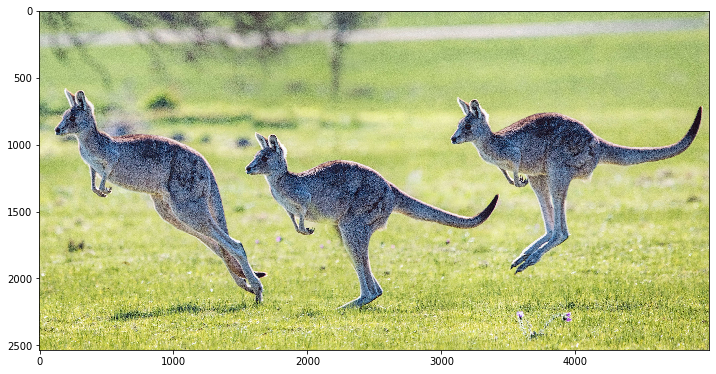

In [0]:
# load image
image = skimage.io.imread('kangaroo.jpg')

# plot image
pyplot.figure(figsize=(12,10))
pyplot.imshow(image)

Use model to detect kangaroos in image

In [0]:
results = model.detect([image], verbose = 1)

r = results[0]

Processing 1 images
image                    shape: (2533, 5000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 5000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Plot image and detected kangaroos


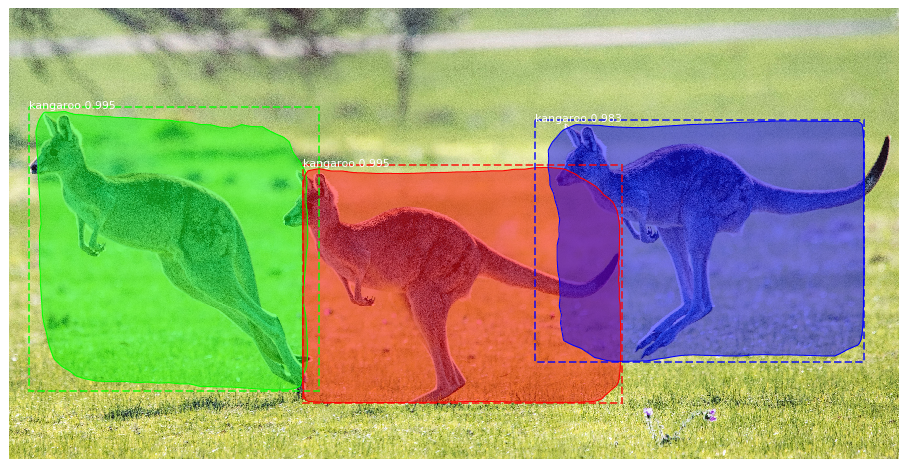

In [0]:
display_instances(image, r['rois'], r['masks'], r['class_ids'], ['BG', 'kangaroo'], r['scores'])